In [121]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Bernoulli, Normal, Categorical, Dirichlet, Uniform, Multinomial, Empirical
from edward.util import Progbar

Create some sample data:

In [2]:
sample_size = 1000
obs_cond = np.random.choice([0,1,2],[sample_size],p=[.7,.1,.2]) # cold = 0, flu = 1, allergies = 2

runny_nose_cold = np.random.choice([0,1],[sample_size],p=[.1,.9])
headache_cold = np.random.choice([0,1],[sample_size],p=[.5,.5])
fever_cold = np.random.choice([0,1],[sample_size],p=[.99,.01])

runny_nose_flu = np.random.choice([0,1],[sample_size],p=[.5,.5])
headache_flu = np.random.choice([0,1],[sample_size],p=[.5,.5])
fever_flu = np.random.choice([0,1],[sample_size],p=[.5,.5])

runny_nose_al = np.random.choice([0,1],[sample_size],p=[.1,.9])
headache_al = np.random.choice([0,1],[sample_size],p=[.99,.01])
fever_al = np.random.choice([0,1],[sample_size],p=[.99,.01])

runny_nose = np.stack([runny_nose_cold,runny_nose_flu,runny_nose_al])
headache = np.stack([headache_cold,headache_flu,headache_al])
fever = np.stack([fever_cold,fever_flu,fever_al])

In [3]:
obs_runny_nose = np.array([runny_nose[j,i] for i,j in enumerate(obs_cond)])
obs_headache = np.array([headache[j,i] for i,j in enumerate(obs_cond)])
obs_fever = np.array([fever[j,i] for i,j in enumerate(obs_cond)])

In [266]:
### prior_conds = Dirichlet(name='prior_probs',alpha=np.array([1.,1.,1.]))
cat_p = tf.Variable(tf.constant([.3,.3,.4]))
cond = Categorical(name='cond', p=tf.ones([sample_size,3])*cat_p)
    
W = tf.Variable(tf.zeros([3,3]),name='W') #Uniform(name='W',a=0.,b=1.,shape=[3,3])
    
runny_nose = Bernoulli(name='runny_nose',logits=tf.gather(W[0,:],cond))
headache = Bernoulli(name='headache',logits=tf.gather(W[1,:],cond))
fever = Bernoulli(name='fever',logits=tf.gather(W[2,:],cond))

In [267]:
inference = ed.MAP({},{cond:obs_cond,runny_nose:obs_runny_nose,headache:obs_headache,fever:obs_fever})

In [268]:
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 1844.628


In [269]:
cat_p.eval()

array([ 1.40192449,  0.22793896,  0.38729435], dtype=float32)

In [14]:
tf.nn.sigmoid(W).eval()

array([[ 0.90935266,  0.48672545,  0.91666663],
       [ 0.49928072,  0.46902663,  0.0010181 ],
       [ 0.0086338 ,  0.47787613,  0.01041685]], dtype=float32)

Hide some of the sample data:

In [21]:
msk_cond = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_cond)
msk_runny_nose = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_runny_nose)
msk_headache = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_headache)
msk_fever = np.ma.masked_where(np.random.rand(sample_size) > .9, obs_fever)

In [24]:
msk_cond.set_fill_value(3)
msk_runny_nose.set_fill_value(2)
msk_headache.set_fill_value(2)
msk_fever.set_fill_value(2)

In [40]:
a = np.concatenate([np.eye(3,dtype=np.float32),np.zeros([1,3],dtype=np.float32)])
b = np.concatenate([np.zeros([3,3],dtype=np.float32),np.ones([1,3],dtype=np.float32)])

In [341]:
#cat_p = Dirichlet(alpha=tf.constant([1.,1.,1.])) #tf.ones([sample_size,3])*
#cond = Categorical(name='cond', p=tf.ones([sample_size,3])*cat_p) 
cond = Categorical(name='cond', p=tf.ones([sample_size,3])*tf.constant([.7,.1,.2])) 

hide_prob = Normal(tf.constant(-3.),1.)
hide_cnd_mat = tf.constant(a.T)*(1-tf.nn.sigmoid(hide_prob))+tf.constant(b.T)*tf.nn.sigmoid(hide_prob)
cond_out = Categorical(name='cond_out',p = (tf.gather(hide_cnd_mat,cond)))
    
#W = tf.Variable(tf.zeros([3,3]),name='W') #Uniform(name='W',a=0.,b=1.,shape=[3,3])

W = Normal(mu=tf.zeros([3,3]),name='W',sigma=tf.ones([3,3])) #Uniform(name='W',a=0.,b=1.,shape=[3,3])
    
runny_nose = Bernoulli(name='runny_nose',logits=tf.gather(W[0,:],cond))
headache = Bernoulli(name='headache',logits=tf.gather(W[1,:],cond))
fever = Bernoulli(name='fever',logits=tf.gather(W[2,:],cond))

In [321]:
inference = ed.MAP({},{cond_out:msk_cond.filled(),runny_nose:obs_runny_nose,headache:obs_headache,fever:obs_fever})

In [322]:
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: inf


In [323]:
tf.nn.sigmoid(W).eval()

array([[ 0.86642259,  0.87893784,  0.84509879],
       [ 0.39862278,  0.40493244,  0.41647154],
       [ 0.06128828,  0.06534473,  0.0617969 ]], dtype=float32)

In [333]:
cond.eval()

array([0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2,
       2, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,
       2, 0,

(array([ 45.,  28.,  14.,   7.,   4.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.00146852,  0.04133982,  0.08121112,  0.12108242,  0.16095372,
         0.20082501,  0.24069631,  0.28056761,  0.32043891,  0.3603102 ,
         0.4001815 ]),
 <a list of 10 Patch objects>)

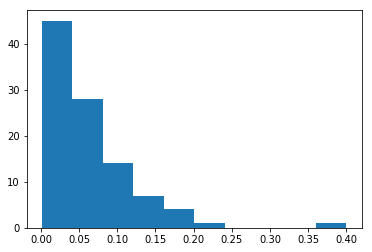

In [197]:
plt.hist(tf.sigmoid(hide_prob.sample(100)).eval())

(array([ 36.,   0.,   0.,   0.,   0.,  27.,   0.,   0.,   0.,  37.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

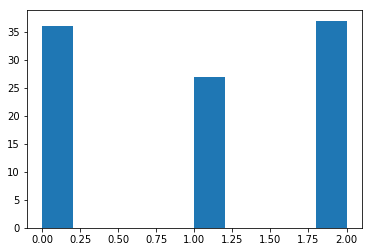

In [298]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([cond.eval()[1] for i in range(100)])

In [294]:
(obs_cond-cond.eval())[2]

1

In [313]:
T = 1000
qcond = Empirical(params=tf.Variable(tf.zeros([T, sample_size],dtype=tf.int32)))


In [314]:
mc_inference = ed.HMC({cond:qcond},{cond_out:msk_cond.filled(),runny_nose:obs_runny_nose,headache:obs_headache,fever:obs_fever})

In [316]:
mc_inference.run(n_iter=100)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [359]:
#cat_p = tf.Variable(tf.constant([.3,.3,.4]))
cond = Categorical(name='cond', logits=tf.zeros([sample_size,3]))#p=tf.ones([sample_size,3])*tf.constant([.3,.3,.4]))
    
W = Normal(mu=tf.zeros([3,3]),name='W',sigma=tf.ones([3,3]))
    
runny_nose = Bernoulli(name='runny_nose',logits=tf.gather(W[0,:],cond))
headache = Bernoulli(name='headache',logits=tf.gather(W[1,:],cond))
fever = Bernoulli(name='fever',logits=tf.gather(W[2,:],cond))

In [360]:
qcondv = Categorical(name='qcondv', logits=tf.Variable(tf.zeros([sample_size,3],dtype=tf.float32)))
qW = Normal(mu=tf.Variable(tf.zeros([3, 3])),sigma=tf.exp(tf.Variable(tf.zeros([3, 3]))))

v_inf = ed.KLqp({W:qW},
                                {cond_out:obs_cond,runny_nose:obs_runny_nose,
                                 headache:obs_headache,fever:obs_fever})


In [361]:
v_inf.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: inf


In [365]:
np.mean(tf.sigmoid(qW.sample(100)).eval(),axis=0)

array([[ 0.85889208,  0.85114264,  0.86116403],
       [ 0.40980232,  0.39238507,  0.39093006],
       [ 0.07248495,  0.0694666 ,  0.06927316]], dtype=float32)